<a href="https://colab.research.google.com/github/PeggyK1/DS-Unit-2-Kaggle-Challenge/blob/master/Peggy_Krom_LS_DS17_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


### Setup

In [206]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [207]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

### Profile Report

In [17]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

### Train/Validation 80/20 Split

In [208]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=31)

print('Train:', train.shape)
print('Validation:', val.shape)
print('Test:', test.shape)

Train: (47520, 41)
Validation: (11880, 41)
Test: (14358, 40)


In [209]:
#Creating Boolean Functional Column
train['functional'] = (train['status_group']=='functional').astype(int)

### Baseline

In [210]:
#Baseline including all 3 unique values for status_group
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [211]:
#Baseline where functional = True or False
train['functional'].value_counts(normalize=True)

1    0.543077
0    0.456923
Name: functional, dtype: float64

### EDA & Feature Engineering

In [212]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 55726 to 52947
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     47520 non-null  int64  
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  object 
 3   funder                 44602 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44582 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47520 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47218 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  int64  
 15

In [213]:
train[['longitude','latitude']].describe()

,longitude,latitude
count,47520.000000,4.752000e+04
mean,34.083804,-5.712896e+00
std,6.595122,2.948255e+00
min,0.000000,-1.164944e+01
25%,33.103181,-8.542866e+00
50%,34.926408,-5.033821e+00
75%,37.194792,-3.327258e+00
max,40.345193,-2.000000e-08


### Wrangle Function

In [214]:
import numpy as np

def wrangle(X):
    """Wrangle dataset splits"""
    
    # Prevent Copy Warning
    X = X.copy()
    
    # Replacing low latitude values with 0
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Changing longitude/latitude 0 values no nan.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # Dropping duplicate and unique columns
    X = X.drop(columns=['quantity_group', 'id'])

    #Changing date_recorded to datetime format
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

    #Engineering date_recorde year feature
    X['date_recorded_yr'] = X['date_recorded'].dt.year
    
    # return the wrangled dataframe
    return X


In [215]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

### Selecting Features

In [216]:
#Setting target (Which pumps are functional)
target = 'status_group'

#Dropping target from X_train features
train_features = train.drop(columns=[target, 'functional'])

#Cardinality
cardinality = train_features.select_dtypes(exclude='number').nunique()

#Numeric Features
numeric = train_features.select_dtypes(include='number').columns.tolist()

#Categorical features with cardinality <=20
categorical = cardinality[cardinality <= 20].index.tolist()

#Combine Numeric and Categorical
features = numeric + categorical

print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'date_recorded_yr', 'basin', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


### Arranging X feature matrices and y target vectors

In [217]:
#Arranging X matrices and y target

#Training set
X_train = train[features]
y_train = train[target]

#Validation set
X_val = val[features]
y_val = val[target]

#Testing
X_test = test[features]

### Pipeline

In [218]:
#Import
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier

In [219]:
#Instantiate
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=31, max_depth=15)
)

In [220]:
#Fit 
pipeline.fit(X_train, y_train);

### Metrics

In [221]:
#Training Accuracy
print('Training Accuracy:', pipeline.score(X_train, y_train))

Training Accuracy: 0.8315867003367003


In [222]:
#Validation Accuracy
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.7631313131313131


###Feature Importances

In [223]:
%matplotlib inline
import matplotlib.pyplot as plt

In [224]:
encoder = pipeline.named_steps['onehotencoder']
encoded_col = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_,encoded_col)

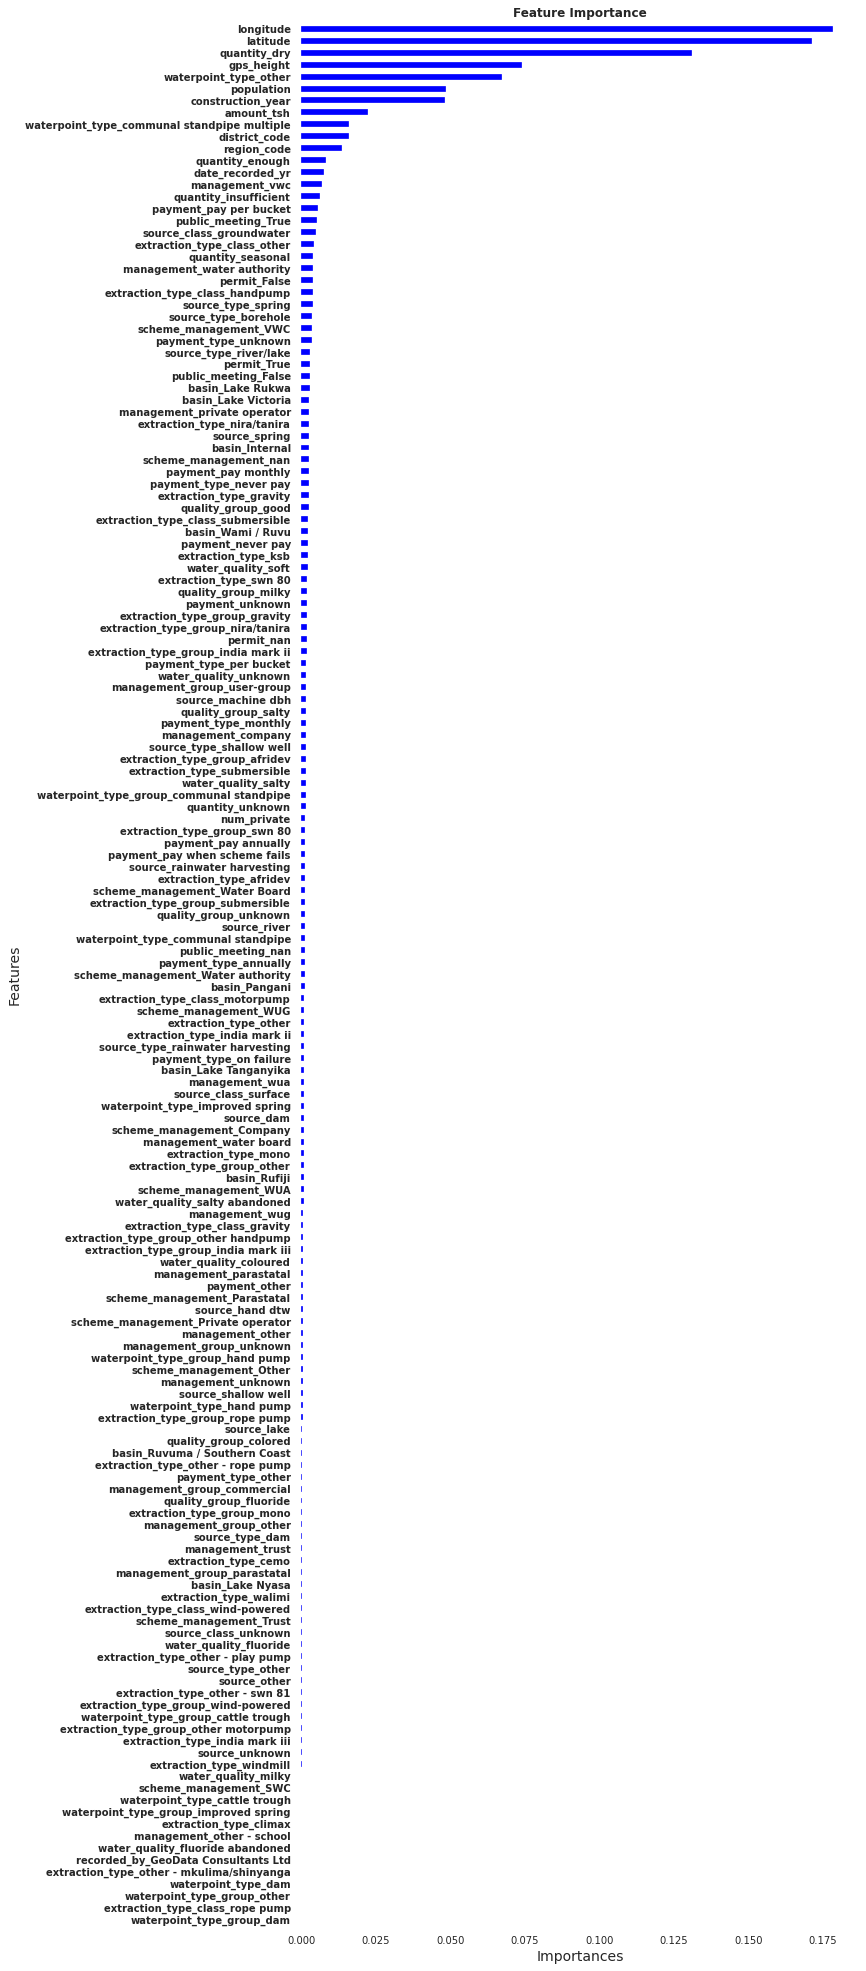

In [167]:
plt.figure(figsize=(10,35))
plt.title('Feature Importance', fontsize='12', fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylabel('Features', fontsize='14')
plt.xlabel('Importances', fontsize='14')
importances.sort_values().plot.barh(color='blue')
plt.show();

### Predictions

In [225]:
y_pred = pipeline.predict(X_test)

In [226]:
Prediction = pd.Series(y_pred)

In [227]:
Prediction.head()

0    non functional
1        functional
2    non functional
3    non functional
4        functional
dtype: object

In [228]:
Prediction.value_counts(normalize=True)

functional                 0.617356
non functional             0.348795
functional needs repair    0.033849
dtype: float64

### Submission

In [229]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

In [230]:
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [234]:
submission.to_csv('Peggy-Krom-Submission.csv', index=False)

In [235]:
submission.shape

(14358, 2)

Decission Tree with Top 10 Features

In [237]:
#Setting target (Which pumps are functional)
target = 'status_group'

#Setting Features
features = ['longitude', 'latitude', 'quantity', 'gps_height', 'waterpoint_type',
            'population', 'construction_year', 'amount_tsh', 'district_code', 'region_code']

#Arranging X matrices and y target
#Training set
X_train = train[features]
y_train = train[target]

#Validation set
X_val = val[features]
y_val = val[target]

#Testing
X_test = test[features]

In [254]:
#Instantiate
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=31, max_depth=15)
)

In [255]:
#Fit 
pipe.fit(X_train, y_train);

In [256]:
#Training Accuracy
print('Training Accuracy:', pipe.score(X_train, y_train))

Training Accuracy: 0.8367213804713804


In [257]:
#Validation Accuracy
print('Validation Accuracy:', pipe.score(X_val, y_val))

Validation Accuracy: 0.7571548821548821


In [261]:
#Prediction
y_pred = pipe.predict(X_test)
Prediction = pd.Series(y_pred)
Prediction.head()

0    non functional
1        functional
2        functional
3    non functional
4        functional
dtype: object

In [262]:
Prediction.value_counts(normalize=True)

functional                 0.620560
non functional             0.346497
functional needs repair    0.032943
dtype: float64